# Home task : KNN classification
1. `iris` dataset
    - load `iris` dataset
    - split to train and test
    - train KNN classifiers for different `K`
    - choose the best `K` determined on test set

2. synthetic dataset
    - generrate synthetic dataset
    - split to train and test
    - train KNN regressors for different `K`
    - choose the best `K` determined on test set
    - visualize the decision boundary 




## `Iris` dataset 

In [8]:
import pandas as pd 
import numpy as np 
import time
import matplotlib.pyplot as plt 
import seaborn as sns




np.random.seed = 2021
from sklearn.datasets import load_iris
iris = load_iris()
print ('data contains:',iris.keys())
X, y, labels, feature_names  = iris.data, iris.target, iris.target_names, iris['feature_names']
df_iris= pd.DataFrame(X, columns= feature_names) 
df_iris['label'] =  y
features_dict = {k:v for k,v in  enumerate(labels)}
df_iris['label_names'] = df_iris.label.apply(lambda x: features_dict[x])



data contains: dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


<H2>Функція для перемішування даних в випадковому порядку </H2>

In [4]:
#функція повертає тренувальний і тест датасети
def split_shuffle(dataframe, percent_train=0.7, label_field='label'):
    
    def split_group_train_test(dataf, label_value):        
        value=dataf.loc[dataf['label']==label_value]        
        percentage=round(len(value)*percent_train)        
        return value.head(percentage), value.tail(len(value)-percentage)   
        
    
    train_df=pd.DataFrame(columns=dataframe.columns)
    test_df=pd.DataFrame(columns=dataframe.columns)
    shuf_df=dataframe.sample(frac=1)
    for i in dataframe.groupby(by=label_field).count().index:
        train_df=pd.concat([train_df,split_group_train_test(shuf_df, i)[0]], axis=0)    
        test_df=pd.concat([train_df,split_group_train_test(shuf_df, i)[1]], axis=0)
    return train_df, test_df 

<h2> Функції для обчислення евклідової відстані, і knn класифікації, і побудова графіка. Для швидшого обчислення переводив
з Pandas в Numpy масив і потім назад  </h2>

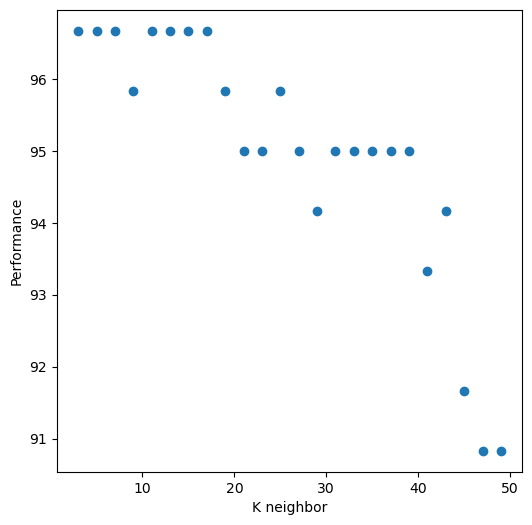

 best k values:[3, 5, 7, 11, 13, 15, 17], score:96.6667
time takes to run numpy func is2.5103044509887695


In [10]:
def euclidean_distance(matrix, row,k):
    subtract=matrix-row    
    squared=np.square(subtract)
    summ=squared.sum(axis=1)    
    sq_root=np.sqrt(summ)
    val=np.argsort(sq_root)[0:k]    
    return val

def knn_classifier(train_data, test_data, k=3, label_field='label'):    
    train_numpy=train_data[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].to_numpy()
    test_numpy=test_data[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].to_numpy()
    list_of_labels=[]    
    for i in test_numpy:        
        index_list=euclidean_distance(train_numpy, i, k)        
        label_val=train_data.iloc[index_list].groupby(by=label_field).count().iloc[:,0].sort_values(ascending=False).head(1).index[0]        
        list_of_labels.append(label_val)
    return list_of_labels

#функція повертає найкращий показник score і один чи кілька K
def run_knn_numpy(train, test):
    perform_dict={}
    K=[]
    perform_list=[]
    for n in range(3,50,2):        
        new_dataframe=test.assign(result=knn_classifier(train, test, k=n))
        correct_val=new_dataframe.where(new_dataframe['label']==new_dataframe['result']).count().iloc[0]
        result=(round(correct_val/len(new_dataframe.index),6))*100
        perform_dict.update({n:result})
        K.append(n)
        perform_list.append(result)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(x=K, y=perform_list)
    plt.xlabel('K neighbor')
    plt.ylabel('Performance')
    plt.show()
    best_values=[key for key, value in perform_dict.items() if value==max(perform_dict.values())]
    return best_values, max(perform_list)    
    
    
#Час який іде на виконання функції
t1=time.time()
result=run_knn_numpy(split_shuffle(df_iris)[0], split_shuffle(df_iris)[1])
print(f' best k values:{result[0]}, score:{result[1]}')
t2=time.time()
print(f'time takes to run numpy func is{t2-t1}') 

<h2>Функція для knn класифікації виключно в Pandas</h2>

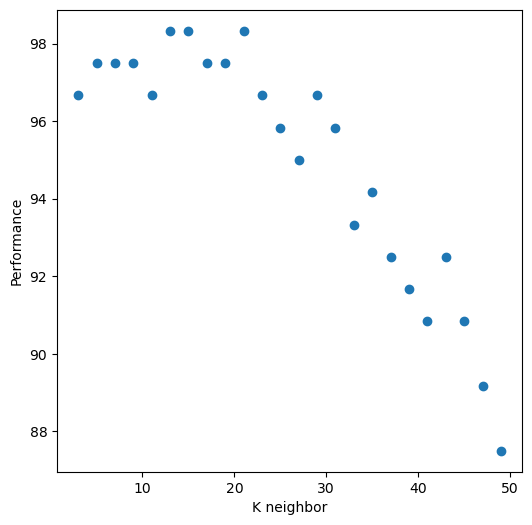

 best k values:[13, 15, 21], score:98.33330000000001
time takes to run pandas func is7.4805474281311035


In [12]:
def knn_using_pandas(train_data, test_data, k=3, label_field='label'):
    columns=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
    list_of_labels=[]
    for ind,i in test_data.iterrows():        
        test_row=i.loc[columns].transpose()        
        soms=train_data[columns].sub(test_row, axis=1)[columns]        
        var=np.sqrt(((soms)**2).sum(axis=1))        
        index_listt=var.sort_values(ascending=True).index[:k]        
        label_val=train_data.loc[index_listt].groupby(by=label_field).count().iloc[:,0].sort_values(ascending=False).head(1).index[0]        
        list_of_labels.append(label_val)
    return list_of_labels


def run_knn_pandas(train, test):
    perform_dict={}
    K=[]
    perform_list=[]
    for n in range(3,50,2):        
        new_dataframe=test.assign(result=knn_using_pandas(train, test, k=n))
        correct_val=new_dataframe.where(new_dataframe['label']==new_dataframe['result']).count().iloc[0]
        result=(round(correct_val/len(new_dataframe.index),6))*100
        perform_dict.update({n:result})
        K.append(n)
        perform_list.append(result)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(x=K, y=perform_list)
    plt.xlabel('K neighbor')
    plt.ylabel('Performance')
    plt.show()
    best_values=[key for key, value in perform_dict.items() if value==max(perform_dict.values())]
    return best_values, max(perform_list)
t1=time.time()
result=run_knn_pandas(split_shuffle(df_iris)[0], split_shuffle(df_iris)[1])
print(f' best k values:{result[0]}, score:{result[1]}')
t2=time.time()
print(f'time takes to run pandas func is{t2-t1}')

<h2>KNN використовуючи sklearn, додав також тренувальний сет, тільки здається він використовує точку яку передбачає для вираховування найближчих, тому результат тест сету кращий</h2>

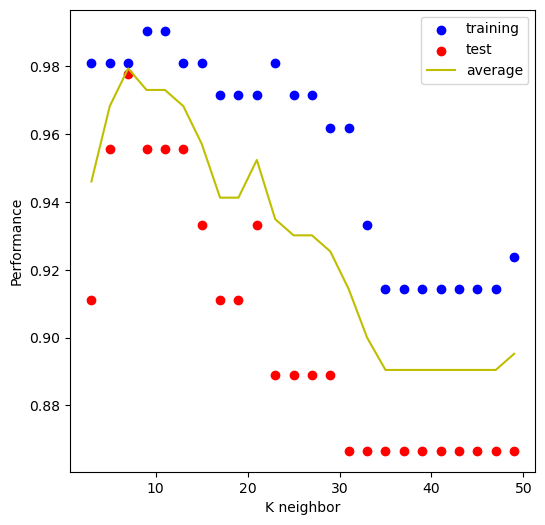

0.2239680290222168
best score is0.9777777777777777 k=7


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler


columns=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
y=df_iris['label']
X=df_iris[columns]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3)


scaler=MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



t1=time.time()
K=[]
training=[]
test=[]
scores={}
for k in range(3,50,2):
    clf=KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    training_score=clf.score(X_train, y_train)
    test_score=clf.score(X_test, y_test)
    K.append(k)
    training.append(training_score)
    test.append(test_score)
    scores[k]=[training_score, test_score]
average=[((x+y)/2) for x,y in zip(training, test)]
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x=K, y=training, c='b', label='training')
ax.scatter(x=K, y=test, c='r', label='test')
ax.plot(K, average, c='y', label='average')
plt.legend(loc='upper right')
plt.xlabel('K neighbor')
plt.ylabel('Performance')
plt.show()
t2=time.time()
print(t2-t1)
print(f'best score is{max(test)} k={K[(test.index(max(test)))]}')

In [22]:
k_best = None # 'compute the best k'
score_best = None #'compute the best score'
print ('The best k = {} , score = {}'.format(k_best,score_best ))

The best k = None , score = None


## Synthetic dataset  

<IPython.core.display.Javascript object>


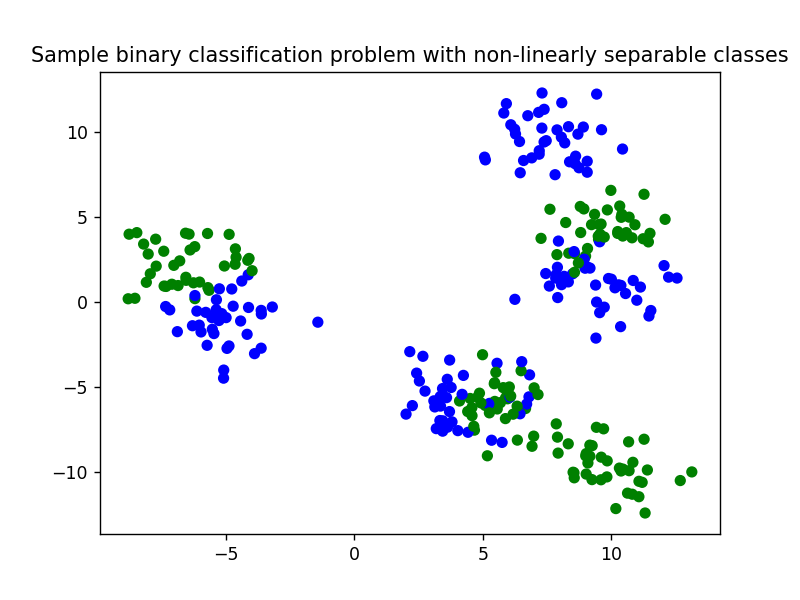

In [26]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib.colors import ListedColormap
cmap_bold = ListedColormap(['blue','#FFFF00','black','green'])

np.random.seed= 2021
X_D2, y_D2 = make_blobs(n_samples = 300, n_features = 2, centers = 8,
                       cluster_std = 1.3, random_state = 4)
y_D2 = y_D2 % 2
plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X_D2[:,0], X_D2[:,1], c=y_D2,
           marker= 'o', s=30, cmap=cmap_bold)



<h2>Генерація точок для decision boundary</h2>

In [31]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors

In [32]:
x=np.arange(-13,13,0.05)
y=np.arange(-9.5,14,0.05)
all_points=np.array([[],[]])
for i in y:    
    new_obj=np.zeros(len(x))
    ar=np.append([new_obj+i],[x], axis=0)
    all_points=np.append(all_points, ar, axis=1)
print(all_points.shape)
all_points=np.transpose(all_points)


(2, 244400)


<h2> Класифікація з різними варіантами підготовки даних перед knn алгоритмом </h2>

<IPython.core.display.Javascript object>


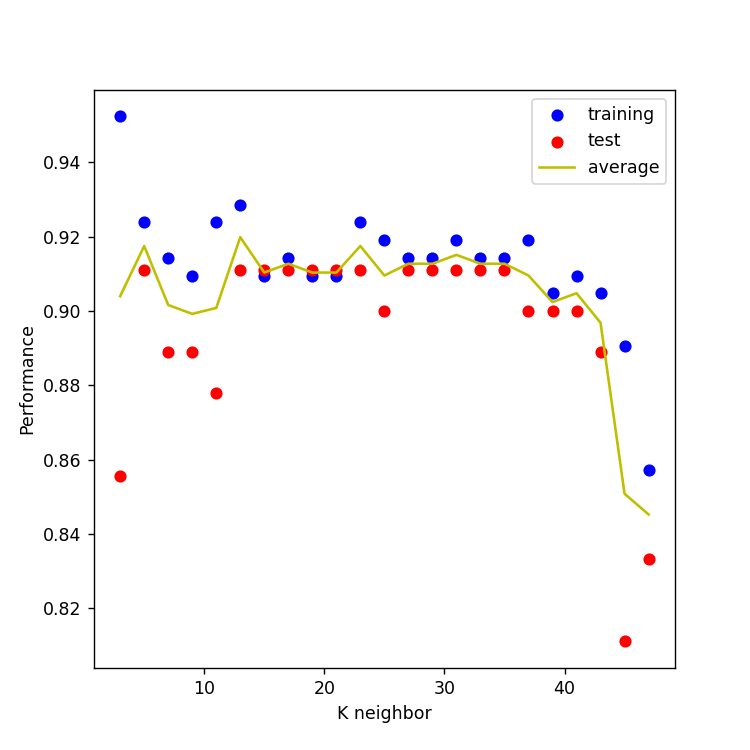

without preprocessing data maximum is 0.9111111111111111, k=5


<IPython.core.display.Javascript object>


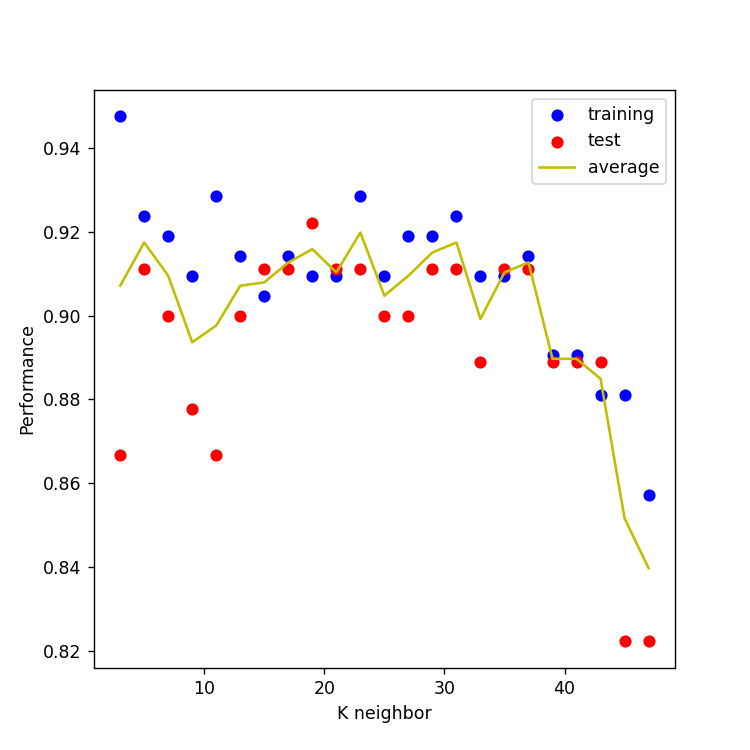

transform data using minMax scaler maximum is 0.9222222222222223, k=19


<IPython.core.display.Javascript object>


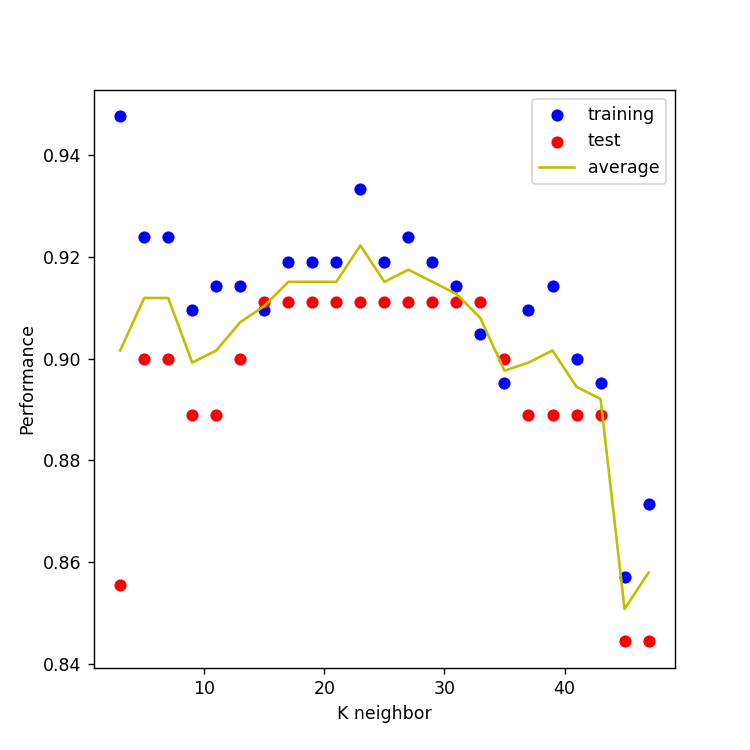

transform data using Standard scaler maximum is 0.9111111111111111, k=15


In [34]:
X_train, X_test, y_train, y_test=train_test_split(X_D2, y_D2, test_size=0.3)
scaler_m = MinMaxScaler()
scaler_st=StandardScaler()
X_train_m_scaled=scaler_m.fit_transform(X_train)
X_test_m_scaled=scaler_m.transform(X_test)
X_train_st_scaled=scaler_st.fit_transform(X=X_train)
X_test_st_scaled=scaler_st.transform(X=X_test)





def classif(X_train, X_test, y_train, y_test):
    K=[]
    training=[]
    test=[]
    scores={}
    for k in range(3,49,2):
        clf=KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train, y_train)
        training_score=clf.score(X_train, y_train)
        test_score=clf.score(X_test, y_test)
        K.append(k)
        training.append(training_score)
        test.append(test_score)
        scores[k]=[training_score, test_score]
    average=[((x+y)/2) for x,y in zip(training, test)]
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(x=K, y=training, c='b', label='training')
    ax.scatter(x=K, y=test, c='r', label='test')
    ax.plot(K, average, c='y', label='average')
    plt.legend(loc='upper right')
    plt.xlabel('K neighbor')
    plt.ylabel('Performance')
    plt.show()
    return f'maximum is {max(test)}, k={K[(test.index(max(test)))]}'
print(f'without preprocessing data {classif(X_train, X_test, y_train, y_test)}')
print(f'transform data using minMax scaler {classif(X_train_m_scaled, X_test_m_scaled, y_train, y_test)}')
print(f'transform data using Standard scaler {classif(X_train_st_scaled, X_test_st_scaled, y_train, y_test)}')

In [216]:
k_best = None # 'compute the best k'
score_best = None #'compute the best score'
print ('The best k = {} , score = {}'.format(k_best,score_best ))

The best k = 18 , score = 0.9466666666666667


<h2>visualize decision boundary</h2> 

<IPython.core.display.Javascript object>


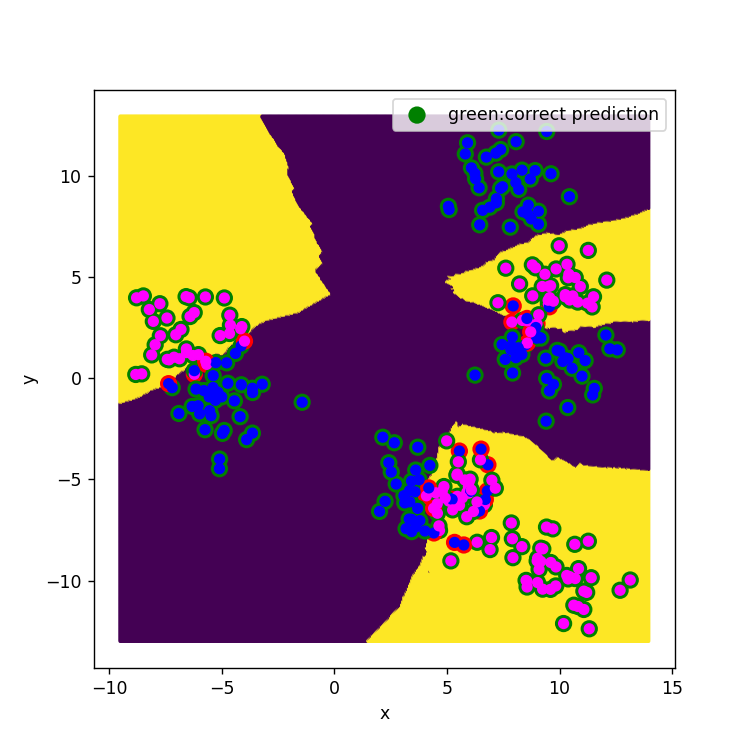

In [36]:
def predict(X_train, y_train):
    clf=KNeighborsClassifier(n_neighbors=19)
    clf.fit(X_train, y_train)
    training_score=clf.score(X_train, y_train)
    data_vector=clf.predict(X_D2)
    y_pred=clf.predict(all_points)
    return y_pred, data_vector
a, data_vector=predict(X_train, y_train)

#червоним позначені точки які класифікатор визначив неправильно
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x=all_points[:,0], y=all_points[:,1], c=a,s=1)
cd=data_vector==y_D2
colors_p=['green' if x==True else 'red' for x in cd]
ax.scatter(x=X_D2[:,0], y=X_D2[:,1], c=colors_p, s=80, label='green:correct prediction')
colors=['blue'if x==0 else 'magenta' for x in y_D2]
ax.scatter(x=X_D2[:,0], y=X_D2[:,1], c=colors, s=30)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.show()